In [1]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *
from chase.cpt import w_prelec

from scipy.stats import norm
from scipy.stats.mstats import mquantiles
    
#from chase.base import *
#from chase.utils import *
#from chase.fit import *

import pickle

PARS = {'theta': [0, 100, 3],
        'p_stay': [0, 1, .1],
        'p_fixed': [0, 1, .1],
        'p_stop_geom': [0, 1, .5],
        'tau': [.001, 50],
        'tau_unif': [0, 1],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 5],
        'w_loss': [0., 10],
        'phi': [0, 100]}

#FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/ssDFE/ssDFE_v3/figures/'

def expected_value(options):
    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    return np.sum(v, 1)


def evar(options):

    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    # expected variance of each option
    evar = np.array([np.dot(weights[i], values[i] ** 2) - np.sum(v[i]) ** 2 for i in range(len(options))])

    return evar

def max_ev(options):
    ev = expected_value(options)
    if ev[0] > ev[1]:
        return [1, 0]
    else:
        return [0, 1]


def max_var(options):
    v = evar(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def cv(options):
    ev = expected_value(options)
    sd = np.sqrt(evar(options))    
    return sd / ev


def max_cv(options):
    v = cv(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def pfix(p):
    c = 1e-5
    return np.min([np.max([p, c]), 1 - c])


P_STOP_GEOM = {'HBWE': .053418,
               'HPKH1': 0.07666,
               'HPKH2': 0.02627}

P_SWITCH = {'HBWE': .25,
            'HPKH1': .185,
            'HPKH2': .11}

cp = {}
bf_cp = {}

quant = {}
bf_quant = {}

N_ITER = 1

In [2]:
problems_str = {0: '4 w/ .8\nvs. 3',
                1: '-3 vs.\n-32 w/ .1',
                2: '-3 vs.\n-4 w/ .8',
                3: '32 w/ .1\nvs. 3',
                4: '32 w/ .025\nvs. 3 w/ .25',
                5: '3 vs.\n5 w/ .55',
                6: '4 w/ .9\nvs. 11 w/ .35',
                7: '-32 w/ .1\nvs. -12 w/ .25',
                8: '-3 w/ .35\nvs. -4 w/ .25'}

In [3]:
FIGDEST = '/Users/markant/code/chase_paper/figures'

In [4]:
from chase.cpt import w_prelec

# compile data

In [36]:
probdf = pd.read_csv('paper/data/frey2014/Frey14_ProblemTable_152.0.txt', sep=' ').reset_index()

In [37]:
Hind = {}
problems = {}

for i, row in probdf.iterrows():

    A = row[['outA1', 'probA1', 'outA2', 'probA2']].values.reshape(2,2)
    B = row[['outB1', 'probB1', 'outB2', 'probB2']].values.reshape(2,2)
    
    ev_A, ev_B = expected_value(np.array([A, B]))
    if ev_A > ev_B:
        Hind[i] = 0
        problems[i] = np.array([B, A], dtype=float)
    else:
        Hind[i] = 1
        problems[i] = np.array([A, B], dtype=float)

In [53]:
arr = []
for i, grp in enumerate(['happy', 'sad', 'fearful', 'angry']):
    dat = pd.read_csv('paper/data/frey2014/Frey14_choice_152.%i.txt' % i, sep=' ')
    dat['group'] = grp
    dat.drop('order', axis=1, inplace=True)
    
    sampdat = pd.read_csv('paper/data/frey2014/Frey14_sampling_152.%i.txt' % i, sep=' ')
    sampdat['group'] = grp
    arr.append(sampdat)

df = pd.concat(arr)

In [57]:
df.groupby(['subject']).apply(lambda d: np.sum(d.option==1)/float(d.shape[0])).values.mean()

0.49646370193780309

In [182]:
arr = []
for i, grp in enumerate(['happy', 'sad', 'fearful', 'angry']):
    dat = pd.read_csv('paper/data/frey2014/Frey14_choice_152.%i.txt' % i, sep=' ')
    dat['group'] = grp
    dat.drop('order', axis=1, inplace=True)
    
    sampdat = pd.read_csv('paper/data/frey2014/Frey14_sampling_152.%i.txt' % i, sep=' ')
    sampdat = sampdat.groupby(['subject', 'problem']).apply(lambda d: d.shape[0]).reset_index()
    sampdat.columns = ['subject', 'problem', 'samplesize']
    
    arr.append(pd.merge(dat, sampdat, on=['subject', 'problem']))
    
data = pd.concat(arr).reset_index()
data['problem'] = data['problem'] - 1
data.drop('index', axis=1, inplace=True)

# recode choices as L/H
arr = []
for i, row in data.iterrows():
    probid = row['problem']
    arr.append(1*(row['choice'] == Hind[probid]))
data['choice'] = np.array(arr)

data.to_csv('paper/data/frey2014/frey2014_data.csv')

In [5]:
data = pd.read_csv('paper/data/frey2014/frey2014_data.csv', index_col=0)

In [31]:
#data = pd.read_csv('paper/data/sixproblems/sixproblems.txt', sep=' ')
#data = data[(data.paper=='Frey14') & (data['special']!='dentist') & (data['special']!='comedy')]
#data.loc[data['problem']==1,'problem'] = 0

In [3]:
#arr = []
#for i, grp in data.groupby(['special', 'problem', 'subject']):
#    group = grp['special'].values[0]
#    problem = grp['problem'].values[0]
#    subject = grp['subject'].values[0]
#    choseH = 1*(grp['choice'].values[0]==grp['exval'].values[0])
#    samplesize = grp.shape[0]
#    arr.append([group, subject, problem, choseH, samplesize])

In [4]:
#data = pd.DataFrame(arr, columns=['group', 'subject', 'problem', 'choice', 'samplesize'])
#data = data[data.samplesize < 200]

In [6]:
data.samplesize.min(), data.samplesize.max()

(2, 369)

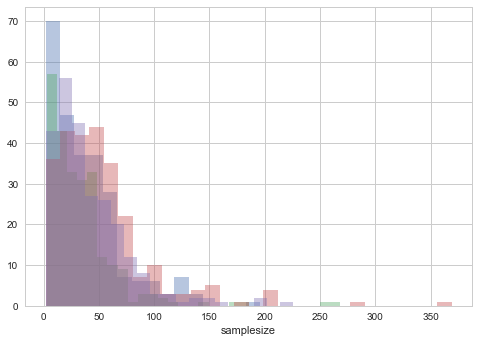

In [114]:
sns.distplot(data[data.group=='angry']['samplesize'], kde=False)
sns.distplot(data[data.group=='happy']['samplesize'], kde=False)
sns.distplot(data[data.group=='fearful']['samplesize'], kde=False)
sns.distplot(data[data.group=='sad']['samplesize'], kde=False)

# Fit stopping distributions

In [30]:
from scipy.stats import geom
from scipy.optimize import minimize

def nloglik_geom(value, data, pars):
    print value
    if value < 0 or value > 1:
        return np.inf
    else:    
        minss = pars.get('minsamplesize', 2)
        ss = data.samplesize.values
        p = geom.pmf(ss, value, loc=(minss-1))
        return -np.sum(np.log(p))
    
def fit_geom(data, pars):
    f = minimize(nloglik_geom, np.random.random(), (data, pars), method='Nelder-Mead', options={'ftol': .0001})
    return f



In [ ]:
P_STOP_GEOM = {}

pars = {'minsamplesize': 2}
for group in ['happy', 'sad', 'fearful', 'angry']:
    
    grpdata = data[data.group==group]
    f = fit_geom(grpdata, pars)
    P_STOP_GEOM[group] = f['x'][0]

In [34]:
P_STOP_GEOM

{'angry': 0.026978608611766125,
 'fearful': 0.019222452540630226,
 'happy': 0.029618441290606409,
 'sad': 0.024462195118869705}

# Fit conditions indvidually

In [40]:
OUTDIR = 'process_planned_fitresults_FHR14'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000}
#FIXED = {'minsamplesize': 2, 'pref_units': 'diffs', 'max_T': 1000, 'N': 20000}

PARSETS = [#['tau'],
           #['tau', 'pow_gain'],
           #['tau', 'prelec_gamma', 'prelec_elevation'],
           ['tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace',
                      stoprule='fixedGeom')

In [42]:
for group in ['happy', 'sad', 'fearful', 'angry']:
    
    grpdata = data[data.group==group]
    SIM_ID = 'process_planned_FHR14_%s' % group
    print SIM_ID
    FIXED['p_stop_geom'] = P_STOP_GEOM[group]
    
    for fitting in PARSETS:

        results = fit_mlh(m, problems, grpdata, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

process_planned_FHR14_happy
pow_gain	prelec_elevation	prelec_gamma	tau
[  0.146   2.072   0.684  33.41 ] 1354.28839291
[  0.901   2.353   0.555  60.24 ] 1340.59053326
[  1.451   2.99    1.753  68.204] 1346.1024168
[  1.874   2.729   0.91   65.353] 1274.06487044
[  1.066   1.541   1.503  51.27 ] 1308.80879051
[  0.084   1.03    0.732  82.375] 1278.16292867
[  1.845   1.128   1.762  87.614] 1319.31045195
[  0.525   2.806   2.359  52.342] 1338.14378707
[  1.313   2.513   1.909  77.166] 1347.07710013
[  1.76    1.193   2.713  88.602] 1385.40481657
[  0.647   0.387   1.108  91.87 ] 1293.19594823
[  1.801   0.819   0.619  30.39 ] 1386.53213004
[  1.999   0.677   1.593  74.752] 1419.71340689
[  1.208   2.495   2.166  20.334] 1349.02316149
[  0.815   0.485   2.658  98.265] 1326.26085451
[  0.219   2.134   2.555  85.321] 1329.81508418
[  0.632   1.231   1.199  42.062] 1280.80513242
[  0.606   1.772   0.019  12.89 ] 1382.39258162
[  1.572   2.344   1.298  41.421] 1311.82935552
[  1.163   1.878  

In [61]:
fitting = PARSETS[3]

best = {}
pred = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    
    best[group] = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred[group] = predict_from_result(m, problems, grpdata, SIM_ID, FIXED, 
                                      fitting = fitting, outdir=OUTDIR)
    print best[group]

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1272.64
k                                                                   5
N                                                                 243
bic                                                           2572.75
pow_gain                                                     0.147909
prelec_elevation                                             0.289349
prelec_gamma                                                  1.43942
tau                                                           21.7337
theta                                                         9.15271
sim_id              process_FHR14_happy(pow_gain,prelec_elevation,...
Name: 0, dtype: obje

In [62]:
for group in ['happy', 'sad', 'fearful', 'angry']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = pred[group]['cp']

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = pred[group][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean()

In [63]:
from mypy.viz import tableau20
cols = [tableau20[0], tableau20[2], tableau20[4], tableau20[6]]
cols = ['black', 'black', 'black', 'black']

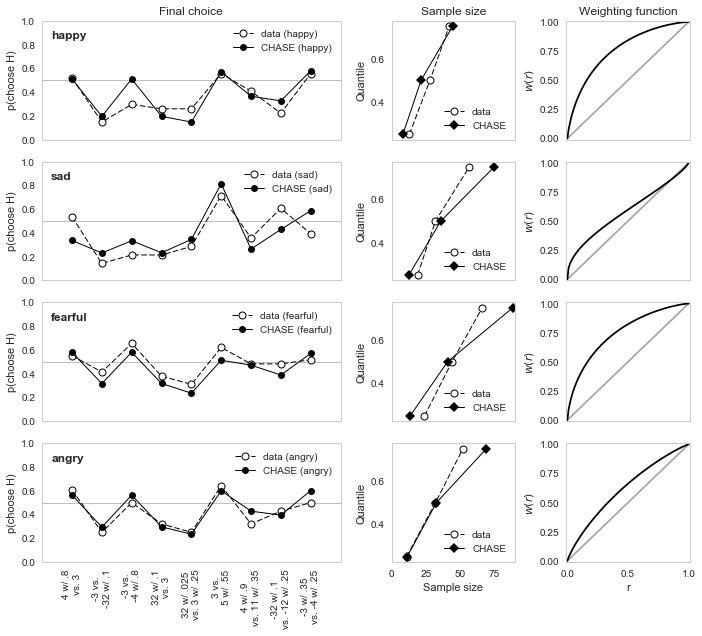

In [64]:
n_prob = len(problems)

fig = plt.subplots(4, 4, figsize=(10, 9), sharex=True)

for j, group in enumerate(['happy', 'sad', 'fearful', 'angry']):


    # choice probs
    axi = plt.subplot2grid((4,4), (j,0), colspan=2)
    axi.text(0.03, .85, group, fontsize=12, fontweight='semibold', transform=axi.transAxes)
    axi.plot([0, n_prob+1], [.5, .5], '-', color='gray', alpha=.5, linewidth=1)
    axi.plot(range(1, n_prob+1), cp[group], '--o', label=('data (%s)' % group), color='black', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(range(1, n_prob+1), bf_cp[group], '-o', color=cols[0], label=('CHASE (%s)' % group), linewidth=1)
    axi.set_ylim(0, 1)
    axi.set_xlim(0, n_prob+1)
    
    if j == 3:
        axi.set_xticks(range(1,n_prob+1))
        axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
        #axi.set_xlabel('Problem')
    else:
        axi.set_xticks([])
    axi.set_ylabel('p(choose H)')
    axi.grid(None)
    
    if j == 0: axi.set_title('Final choice')
    axi.legend(loc='upper right')

    # sample size
    axi = plt.subplot2grid((4,4), (j,2))
    axi.plot(quant[group], [.25, .5, .75], '--o', color=cols[0], label='data', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(bf_quant[group], [.25, .5, .75], '-D', color=cols[0], label='CHASE', linewidth=1)

    if j == 0: axi.set_title('Sample size')
    axi.set_xlim(0, 90)
    #axi.legend(loc='upper left')
    if j == 3:
        axi.set_xlabel('Sample size')
    else:
        axi.set_xticks([])
    axi.set_ylabel('Quantile')
    

    axi.legend(loc='lower right')
    axi.grid(None)




    p = np.arange(0, 1.01, .01)


    axi = plt.subplot2grid((4,4), (j,3))
    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)


    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0])

    if j == 0: axi.set_title('Weighting function')
    axi.set_ylabel(r'$w(r)$')
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)



plt.tight_layout()
plt.show()
fig[0].savefig('%s/fitresults_frey2014_bygroup.pdf' % FIGDEST, bbox_inches='tight')

In [65]:
groups = ['happy', 'sad', 'fearful', 'angry']

colnames = ['nllh', 'k', 'N', 'bic', 'theta', 'tau', 'pow_gain', 'prelec_elevation', 'prelec_gamma']
fitdf = pd.DataFrame([best[group][colnames] for group in groups]).reset_index()
fitdf['group'] = groups

In [66]:
fitdf

,index,nllh,k,N,bic,theta,tau,pow_gain,prelec_elevation,prelec_gamma,group
0,0,1272.640886,5,243,2572.747079,9.152707,21.733738,0.147909,0.289349,1.439423,happy
1,0,1378.155559,5,252,2783.958263,14.577687,18.365253,0.369194,0.690577,0.798873,sad
2,0,1519.930815,5,261,3067.684231,17.178882,28.145506,0.302148,0.317919,1.332257,fearful
3,0,1350.289115,5,252,2728.225375,17.507921,11.345784,0.541849,0.624433,1.136634,angry


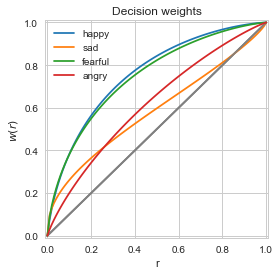

In [205]:
p = np.arange(0, 1.01, .01)

fig, axi = plt.subplots(figsize=(4,4))

for i, group in enumerate(['happy', 'sad', 'fearful', 'angry']):

    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[i], label=group)

    axi.set_title('Decision weights')
    axi.set_ylabel(r'$w(r)$')
    axi.set_xlabel('r')
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)
plt.show()

In [197]:
PARSETS

[['theta', 'tau'],
 ['theta', 'tau', 'pow_gain'],
 ['theta', 'tau', 'prelec_gamma', 'prelec_elevation'],
 ['theta', 'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation']]

# Fit conditions individually (p_switch)

In [46]:
SWITCH_RATE = {'happy': .08,
               'fearful': .04,
               'angry': .06,
               'sad': .05}

In [47]:
OUTDIR = 'process_fitresults_FHR14_pswitch'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000, 'switchfirst': True}

PARSETS = [#['theta', 'tau'],
           #['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [48]:
#for group in ['happy', 'sad', 'fearful', 'angry']:
for group in ['fearful']:
    
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    print SIM_ID
    
    FIXED['p_switch'] = SWITCH_RATE[group]
    
    for fitting in PARSETS:

        results = fit_mlh(m, problems, grpdata, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

process_FHR14_fearful
pow_gain	prelec_elevation	prelec_gamma	tau	theta


process_model.py:78: RuntimeWarning: invalid value encountered in divide
  w_outcomes[0] = w_outcomes[0] - phi
process_model.py:364: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  'traces': traces
process_model.py:349: RuntimeWarning: invalid value encountered in divide
  sampled_option = [sampled_option[i][:(samplesize[i]+1)] for i in range(samplesize.shape[0])]


[  5.90000000e-02   1.48800000e+00   1.69300000e+00   9.73010000e+01
   4.30870000e+01] 1901.71549984
[  0.994   1.455   2.641  46.069  10.197] 2266.38915113
[  0.295   0.144   2.696  39.813  22.073] 1571.54588224
[  1.265   2.521   2.004   7.395  16.527] 2246.8603616
[  1.143   2.446   2.497  60.369  38.625] 2036.64193842
[  1.539   0.535   2.917  27.394  16.79 ] 2252.90188555
[  1.106   2.014   1.921  95.318  23.739] 2049.26669106
[  1.855   2.786   1.329  88.11    9.899] 2272.8838951
[  0.882   0.864   2.953  29.926  34.821] 1847.00400728
[  1.041   2.432   0.071   2.566  33.086] 1690.88030303
[  1.656   0.807   1.884  33.564  35.864] 2226.40699979
[  0.575   2.313   1.137  12.231  40.145] 1861.40266741
[  0.851   2.235   0.575  25.113   2.502] 2415.69700972
[  0.509   1.736   0.175  62.824  42.24 ] 1617.89013566
[  0.669   2.329   1.253  77.598  48.047] 1877.60862315
[  1.80000000e-02   1.84100000e+00   2.00000000e-02   5.71320000e+01
   1.11810000e+01] 1624.62845695
[  8.80000000e

process_model.py:346: RuntimeWarning: invalid value encountered in divide
  outcome_ind = None


[  1.621   2.848   0.121  74.226   0.297] 2762.88932285
[  0.945   1.624   0.321  41.452  31.64 ] 1636.37854784
[  1.198   0.107   0.899  73.244  21.946] 2309.49597582
[  1.577   0.647   2.049  31.635  37.301] 2177.39507421
[  1.169   1.557   0.719  83.898   6.077] 2414.44956556
[  1.474   1.351   2.806  37.789  17.897] 2283.21194892
[  0.773   0.481   0.24   89.414   6.55 ] 2440.0207708
[  1.405   0.336   0.372  23.995  30.693] 2211.39757979
[  1.574   2.18    1.761  14.478  12.08 ] 2300.6597186
[  0.435   0.753   1.8    36.971  26.666] 1621.97162395
[  0.178   1.367   0.445  62.617  34.694] 1655.65228004
[  1.37    0.308   0.533  84.63   48.857] 1983.16218448
[  0.787   0.668   2.538  93.345  29.443] 1800.45257493
[  1.082   1.678   1.23    5.028  36.036] 1714.8785503
[  0.916   2.989   2.858  57.37   40.957] 2085.09847514
[  1.97700000e+00   4.80000000e-02   7.59000000e-01   6.49250000e+01
   3.77140000e+01] 2437.66023843
[  0.142   2.057   2.999  59.846  46.304] 2062.92381751
[  1.

KeyboardInterrupt: 

In [35]:
fitting = PARSETS[0]

best = {}
pred = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    FIXED['p_switch'] = SWITCH_RATE[group]

    best[group] = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred[group] = predict_from_result(m, problems, grpdata, SIM_ID, FIXED, 
                                      fitting = fitting, outdir=OUTDIR)
    print best[group]

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1241.47
k                                                                   5
N                                                                 243
bic                                                            2510.4
pow_gain                                                    0.0285693
prelec_elevation                                             0.269865
prelec_gamma                                                  1.38986
tau                                                           43.0577
theta                                                         13.6943
sim_id              process_FHR14_happy(pow_gain,prelec_elevation,...
Name: 0, dtype: obje

In [42]:
for group in ['happy', 'sad', 'fearful', 'angry']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = pred[group]['cp']

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = pred[group][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean()

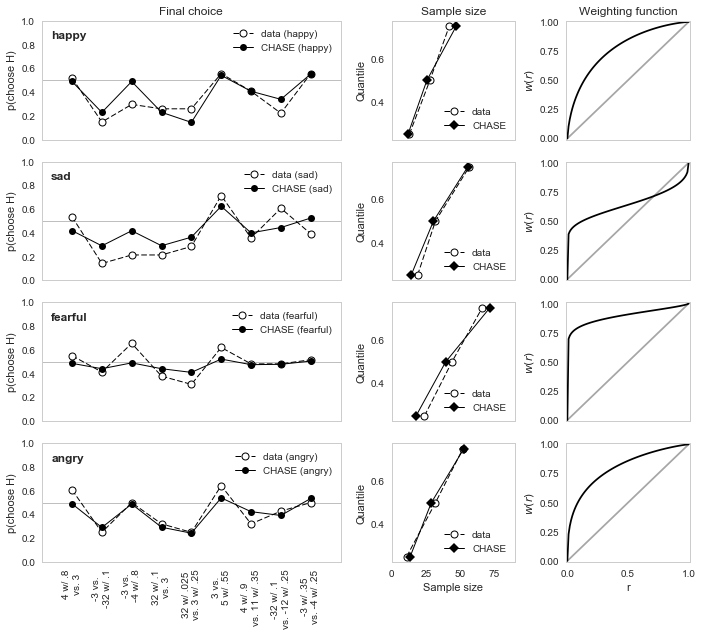

In [43]:
from mypy.viz import tableau20
cols = [tableau20[0], tableau20[2], tableau20[4], tableau20[6]]
cols = ['black', 'black', 'black', 'black']

n_prob = len(problems)

fig = plt.subplots(4, 4, figsize=(10, 9), sharex=True)

for j, group in enumerate(['happy', 'sad', 'fearful', 'angry']):


    # choice probs
    axi = plt.subplot2grid((4,4), (j,0), colspan=2)
    axi.text(0.03, .85, group, fontsize=12, fontweight='semibold', transform=axi.transAxes)
    axi.plot([0, n_prob+1], [.5, .5], '-', color='gray', alpha=.5, linewidth=1)
    axi.plot(range(1, n_prob+1), cp[group], '--o', label=('data (%s)' % group), color='black', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(range(1, n_prob+1), bf_cp[group], '-o', color=cols[0], label=('CHASE (%s)' % group), linewidth=1)
    axi.set_ylim(0, 1)
    axi.set_xlim(0, n_prob+1)
    
    if j == 3:
        axi.set_xticks(range(1,n_prob+1))
        axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
        #axi.set_xlabel('Problem')
    else:
        axi.set_xticks([])
    axi.set_ylabel('p(choose H)')
    axi.grid(None)
    
    if j == 0: axi.set_title('Final choice')
    axi.legend(loc='upper right')

    # sample size
    axi = plt.subplot2grid((4,4), (j,2))
    axi.plot(quant[group], [.25, .5, .75], '--o', color=cols[0], label='data', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(bf_quant[group], [.25, .5, .75], '-D', color=cols[0], label='CHASE', linewidth=1)

    if j == 0: axi.set_title('Sample size')
    axi.set_xlim(0, 90)
    #axi.legend(loc='upper left')
    if j == 3:
        axi.set_xlabel('Sample size')
    else:
        axi.set_xticks([])
    axi.set_ylabel('Quantile')
    

    axi.legend(loc='lower right')
    axi.grid(None)




    p = np.arange(0, 1.01, .01)


    axi = plt.subplot2grid((4,4), (j,3))
    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)


    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0])

    if j == 0: axi.set_title('Weighting function')
    axi.set_ylabel(r'$w(r)$')
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)



plt.tight_layout()
plt.show()
#fig[0].savefig('%s/fitresults_frey2014_bygroup.pdf' % FIGDEST, bbox_inches='tight')

In [44]:
groups = ['happy', 'sad', 'fearful', 'angry']

colnames = ['nllh', 'k', 'N', 'bic', 'theta', 'tau', 'pow_gain', 'prelec_elevation', 'prelec_gamma']
fitdf = pd.DataFrame([best[group][colnames] for group in groups]).reset_index()
fitdf['group'] = groups

In [45]:
fitdf

,index,nllh,k,N,bic,theta,tau,pow_gain,prelec_elevation,prelec_gamma,group
0,0,1241.466137,5,243,2510.397581,13.694268,43.057746,0.028569,0.269865,1.389858,happy
1,0,1338.550289,5,252,2704.747724,15.702699,39.786267,0.012799,0.518055,0.395953,sad
2,0,1459.521819,5,261,2946.866241,28.370094,48.000452,0.044146,0.126165,0.688497,fearful
3,0,1322.364975,5,252,2672.377096,16.568555,52.557158,0.011750,0.235685,1.198122,angry


### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HBWE04'
OUTDIR = 'process_baseline_fitresults_HBWE04'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [448]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,696.178344,1,150,1397.367324,0.053418


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HBWE04'
OUTDIR = 'process_2stage_fitresults_HBWE04'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': .053418}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [451]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,664.271416,4,150,1348.585372,0.363671,0.31345,1.542747,2.729099


In [452]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_switch': .25,
            'p_stop_geom': .053418,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

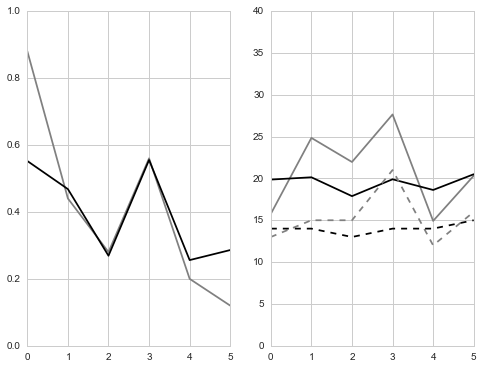

In [453]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
SIM_ID = 'process_HBWE04'
OUTDIR = 'process_fitresults_HBWE04'
FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': .053418}
PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [455]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,716.13854,5,150,1457.330257,-0.000852,0.808129,0.995768,1.261691,0.643931


In [456]:
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

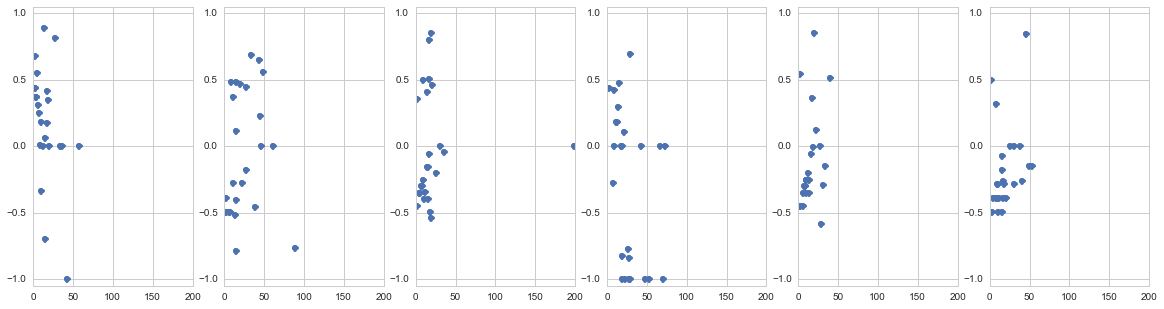

In [457]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [461]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'p_switch': .25,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

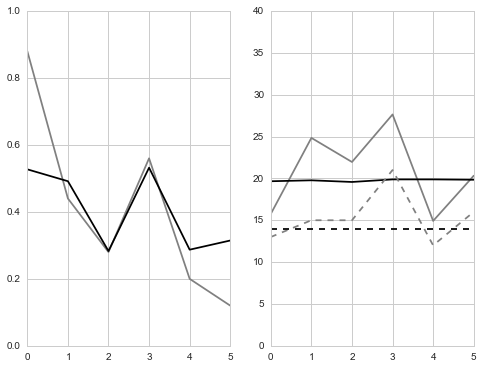

In [462]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_hertwig2004'
OUTDIR = 'process_fitresults_hertwig2004'

FIXED = {'minsamplesize': 2,
         'p_switch': .25}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [428]:
results

,iteration,success,nllh,k,N,bic,p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta
0,0,False,1305.835059,6,150,2641.73393,0.100995,0.561866,1.208618,1.073574,0.601972,2.784131


In [429]:
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 0,
            'tau': results.loc[0]['tau'],
            'theta': results.loc[0]['theta'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

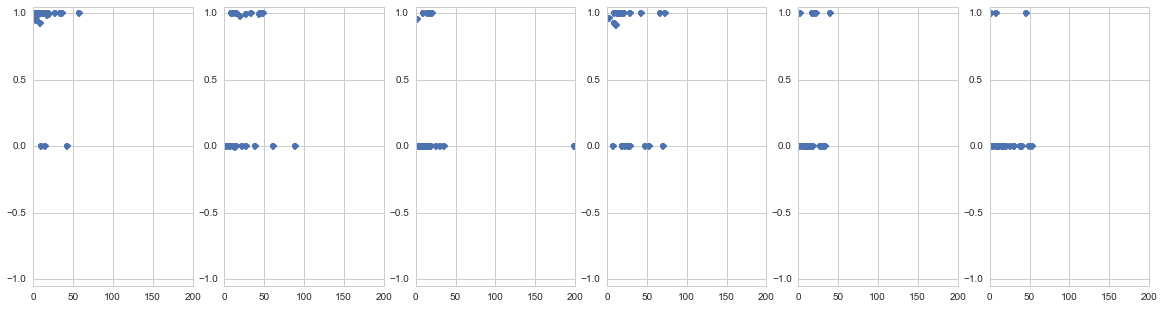

In [430]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [432]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_switch': .25,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

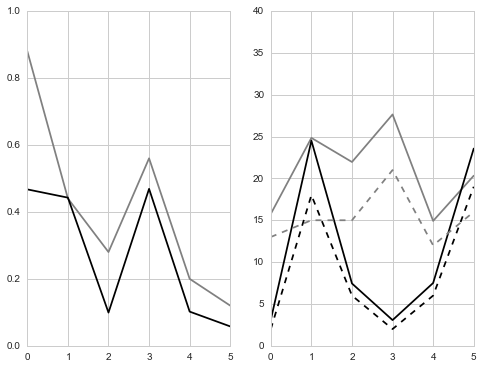

In [433]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

# Hau et al. (2008) - Experiment 1

In [ ]:
from mypy.explib.hau2008 import hau2008
HPKH1_data = hau2008.trial_data(study=1)

### Baseline

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HPKH1'
OUTDIR = 'process_baseline_fitresults_HPKH1'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [435]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,971.079115,1,230,1947.596308,0.07666


### Two-stage + geom

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel
N_ITER = 1
SIM_ID = 'process_2stage_HPKH1'
OUTDIR = 'process_2stage_fitresults_HPKH1'
FIXED = {'minsamplesize': 2,
         'p_stop_geom': .07666}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [437]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,902.001973,4,230,1825.756263,0.318952,0.60701,0.65675,4.775384


In [438]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

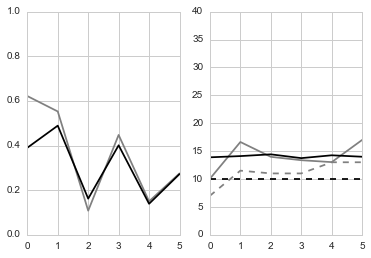

In [440]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_switch': .185,
         'p_stop_geom': .07666}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [464]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,978.880092,5,230,1984.95058,0.000303,0.615612,1.175495,1.13464,0.540726


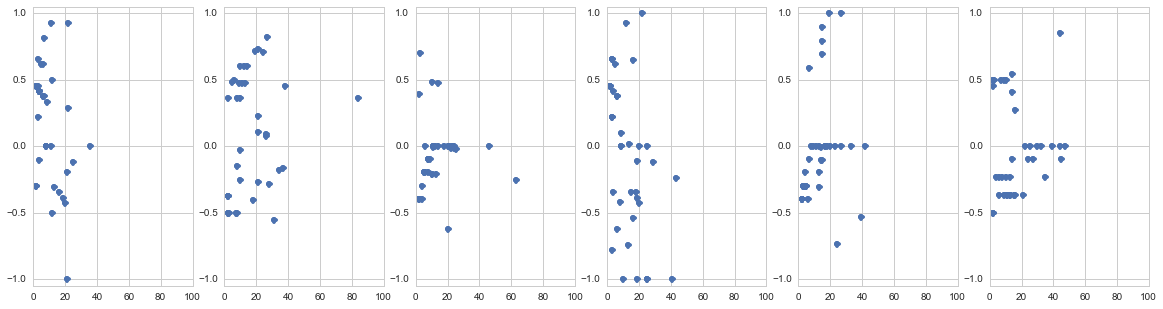

In [469]:
pred = {}
arr = []
for d in HPKH1_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [470]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'p_switch': .185,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

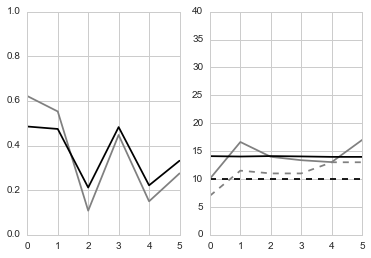

In [471]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional)

In [446]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_switch': .185}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

p_stay	pow_gain	prelec_elevation	prelec_gamma	tau	theta
[ 0.1  1.   1.   1.   0.5  3. ] 2218.26060337 29.2593390942
[ 0.105  1.     1.     1.     0.5    3.   ] 2214.81868901 30.4063830376
[ 0.1   1.05  1.    1.    0.5   3.  ] 2225.2878659 31.8709230423
[ 0.1   1.    1.05  1.    0.5   3.  ] 2213.92925523 33.0243399143
[ 0.1   1.    1.    1.05  0.5   3.  ] 2212.7794734 32.9617190361
[ 0.1    1.     1.     1.     0.525  3.   ] 2196.50652517 31.0505108833
[ 0.1   1.    1.    1.    0.5   3.15] 2224.99277198 30.456193924
[ 0.102  0.95   1.017  1.017  0.508  3.05 ] 2207.18330184 30.4067790508
[ 0.102  0.983  1.022  1.022  0.511  2.867] 2191.41094463 30.4521679878
[ 0.103  0.975  1.033  1.033  0.517  2.725] 2149.34119405 27.1496319771
[ 0.103  0.975  1.033  1.033  0.517  2.925] 2205.91976808 26.9705290794
[ 0.098  0.967  1.044  1.044  0.522  2.9  ] 2174.99396264 28.9825470448
[ 0.102  0.956  0.993  1.059  0.53   2.867] 2149.09493142 28.6417989731
[ 0.103  0.933  0.964  1.089  0.544  2.8  ] 214

KeyboardInterrupt: 

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .25,
            #'phi': results.loc[0]['phi'],
            'p_fixed': results.loc[0]['p_fixed'],
            'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,40)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems])
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems])
ax.set_ylim(0,40)
plt.show()

# Hau et al (2008) - Experiment 2

In [ ]:
HPKH2_data = hau2008.trial_data(study=2)

In [472]:
# confirm the right choice proportions and sample sizes
for pid in range(6):
    data = filter(lambda d: d['probid']==pid, HPKH2_data)
    print pid, np.round(np.mean([d['choice'] for d in data]), 2), np.median([d['samplesize'] for d in data])

0 0.56 27.0
1 0.51 38.0
2 0.36 27.0
3 0.36 35.0
4 0.36 34.0
5 0.46 33.0


In [ ]:
arr = []
for d in HPKH2_data:
    sampled_option = d['sampled_option']
    outcomes = d['outcomes']
    sum_L = np.sum(outcomes[sampled_option==0])
    sum_H = np.sum(outcomes[sampled_option==1])
    arr.append([d['probid'], sum_H - sum_L, d['choice']])
df = pd.DataFrame(arr, columns=['problem', 'diff', 'choice'])

sns.lmplot(x="diff", y="choice", data=df,
           logistic=True, y_jitter=.03)

sns.lmplot(x="diff", y="choice", data=df[(df['diff'] < 100) & (df['diff'] > -100)],
           logistic=True, y_jitter=.03)

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel
N_ITER = 1
SIM_ID = 'process_baseline_HPKH2'
OUTDIR = 'process_baseline_fitresults_HPKH2'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom', 'p_switch']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [474]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,1244.818071,1,234,2495.091464,0.02627


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HPKH2'
OUTDIR = 'process_2stage_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [488]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,1222.658089,4,234,2467.137463,0.515943,0.719596,0.766813,1.699336


In [490]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

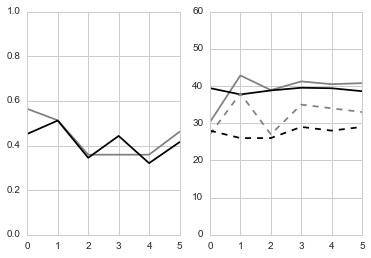

In [491]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,60)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot(df.groupby('probid').apply(lambda d: d.cp.mean()).values)
ax.set_ylim(0,1)
plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [493]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,1316.584042,5,234,2660.444689,0.000433,0.833131,1.167528,0.761687,0.655597


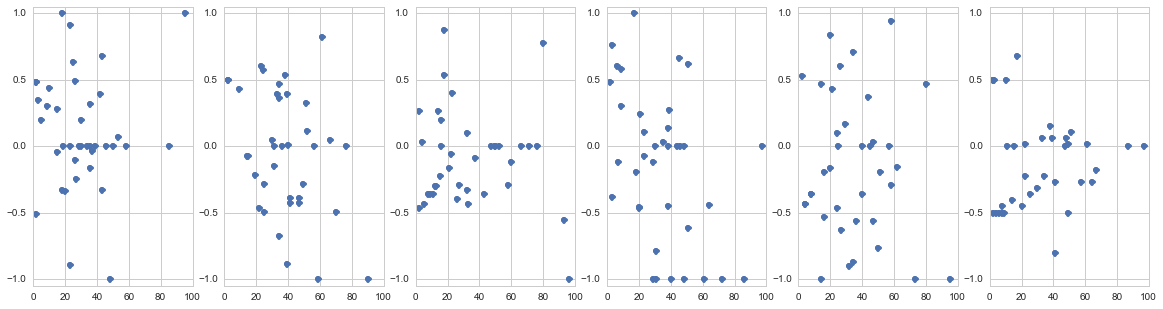

In [483]:
pred = {}
arr = []
for d in HPKH2_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [498]:
for pid in range(6):
    print pid
    print problems[pid]

0
[[[ 3.   1. ]
  [ 0.   0. ]]

 [[ 4.   0.8]
  [ 0.   0.2]]]
1
[[[ 3.    0.25]
  [ 0.    0.75]]

 [[ 4.    0.2 ]
  [ 0.    0.8 ]]]
2
[[[-32.    0.1]
  [  0.    0.9]]

 [[ -3.    1. ]
  [  0.    0. ]]]
3
[[[-4.   0.8]
  [ 0.   0.2]]

 [[-3.   1. ]
  [ 0.   0. ]]]
4
[[[  3.    1. ]
  [  0.    0. ]]

 [[ 32.    0.1]
  [  0.    0.9]]]
5
[[[  3.00000000e+00   2.50000000e-01]
  [  0.00000000e+00   7.50000000e-01]]

 [[  3.20000000e+01   2.50000000e-02]
  [  0.00000000e+00   9.75000000e-01]]]


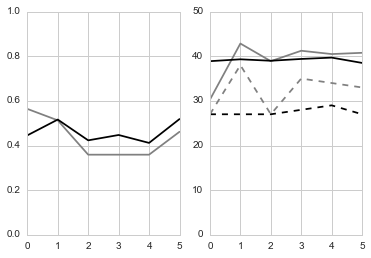

In [495]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'p_switch': P_SWITCH['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,50)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
{0: -26.994788602372655,
 1: -22.985235037285271,
 2: -16.927245225174545,
 3: -27.251149138644049,
 4: -26.746905508212905,
 5: -19.132769547444727}

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
lm = sns.lmplot(x="samplesize", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(0,100)

In [ ]:
lm = sns.lmplot(x="cp", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(-.05,1.05)

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_switch': .1}

PARSETS = [#['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'p_fixed', 'prelec_gamma', 'prelec_elevation'],
            ['theta', 'pow_gain', 'prelec_gamma', 'prelec_elevation']
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation', 'prelec_gamma_loss', 'prelec_elevation_loss', 'pow_gain']
          ]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='indifferent')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .1,
            #'phi': results.loc[0]['phi'],
            #'p_fixed': results.loc[0]['p_fixed'],
            #'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,50)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], color='black')
ax.set_ylim(0,40)
plt.show()

In [ ]:
pred[0]['samplesize']

In [ ]:
fig, axi = plt.subplots(2, 6, figsize=(15,8))

for pid in range(6):
    sns.distplot(data[data.problem==pid].samplesize.values, kde=False, ax=axi[1][pid])
    sns.distplot(pred[pid]['samplesize'], kde=False, ax=axi[0][pid], color='gray')
    
for i in range(2):
    for j in range(6):
        axi[i][j].set_xlim(0,200)

In [ ]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

# Recovery

In [ ]:
from cogmod import cpt as cptmodel

def fit_chase(problems, data, fit_pars):
        
    FIXED = {'dt': .1}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [1, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [ ]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
#problems = {i: arr[i].reshape((2,2,2)) for i in range(1)}
#problems = [arr[i].reshape((2,2,2)) for i in range(len(arr))]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)